# Report project basic of mobile robotics - group 17
## 1. About us
The group is composed by:
- <b>300780</b> - Martin Samuel Rollet (Local Navigation): *1st year Master student in robotics, with a Bachelor of microengineering from EPFL. Interested in multidisciplinary projects, particularly involving mechanics, programming, robotics and electronics.*
- <b>302699</b> - Louis Eric Hubert Flahault (Filtering): *2nd year Master student in robotics, with a Bachelor of microengineering from EPFL and a Minor in Computer Science. Interested in Computer Vision, data analysis and mobile robotics.*
- <b>327695</b> - Nina Lahellec (Global Navigation): *1st year Master student in robotics with a Bachelor of mechanical engineering from EPFL. I am interested in mobile robotics, but still discovering all the fields of robotics!*
- <b>352298</b> - Alessandro Dalbesio (Vision): *2nd year Master student in robotics with a Bachelor in automation and control engineering from Politecnico di Milan (Italy). I'm interested in computer vision and machine learning.*

## 2. Introduction
This project aims to maneuver a Thymio robot on a map towards a goal. 
The environment chosen uses a camera, the Thymio robot, and a map, as seen in the image below.

* The **camera** is put on top of a chair which is itself on top of a table, in order to have a global vision of the map.

* The **Thymio** is localised by a ArUco marker on its upper face, which serves also as initial point.

* The **map** gathers:
    * a background environment made of 4x4 white A4 papers;
    * corners delimited by ArUco markers;
    * obstacles represented as black convex polygons;
    * a goal point defined by an ArUco marker.

<br>
<center><img src="./_report_data/img/environment_setting.jpg" width = 30% height = 30%></center>


This project combines vision, path planning, local navigation, and filtering. The scheme below summarizes the global approach of the project:
<br>
<center><img src="./_report_data/img/code_schema.png" width = 70% height = 70%></center>

## 3. Computer Vision
The code implemented for the vision part is split in three classes (each one in a different file):
- `camera.py`: This class implements all the methods needed to work with the camera (image acquisition, real time display, ...)
- `markers.py`: This class implements all the methods needed to work with ArUco markers (detection and creation).
- `map.py`: This class implements all the methods needed to work with the map (obstacles detection, position and orientation estimation, goal detection,...)
### 3.1. Map creation
The <u>map</u> has black obstacles and a white background.<br>
The <u>working area of the robot</u> is defined with four ArUco markers. The vertices of these markers are on the vertices of the map so that we know where the real vertices are. This is used to compute the perpective transform matrix and, since we know the dimension of the working area of the robot, to convert the coordinates of the points in the map from pixels to meters. This conversion is needed to estimate the position of the robot with the Kalman filter.<br>
The <u>final goal</u> is defined with an ArUco marker. <br>
The <u>initial goal</u> and the real time position and orientation of the robot are measured with an ArUco marker. <br><br>
A brief description of the ArUco markers used in the project is given below.

#### 3.1.0 ArUco markers
ArUco markers serve as reference points in a real-world environment for computer vision systems. <br>
ArUco markers are typically square-shaped black and white patterns. The pattern includes a unique binary code (which let us identify the marker) embedded in a grid, and the corners of the markers are used as reference points for accurate pose estimation. Below is an example of an ArUco marker. <br>
The ID used in this project are defined in the file `settings.py`. <br>
Their use is widespread in augmented reality applications and robotics thanks to the fact that they are easy to detect even in not perfect light conditions. <br>
The library used to detect and create ArUco markers is `cv2.aruco` from OpenCV that provides a easy-to-use interface to work with them. <br>
The robustness provided from these markers even in not perfect light conditions and the easy-to-use interface provided by OpenCV make them a good choice for this project. <br>
<center><img src="./_report_data/img/ArUco_marker.jpg" alt="ArUco marker" width="20%"></center>

#### 3.1.1 Data loading and needed variables initialization

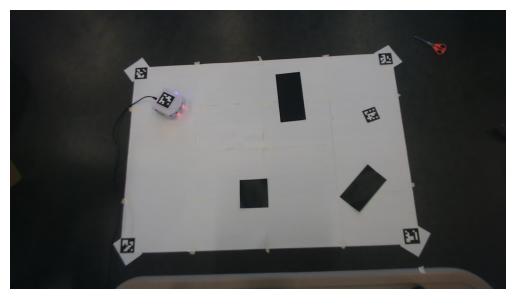

In [2]:
# Import libraries needed
from vision.map import * # Import map library
from global_navigation.main import *
from vision.camera import *
from utils.settings import *

# Prepare data for the demo
camera_frame_path = "_report_data/img/map_img.jpg"

# Initialize the map (load an image from a file) 
cam = Camera(frame_path=camera_frame_path)
frame,_ = cam.get_frame()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(frame)
plt.axis('off')
plt.show()

#### 3.1.2 Corners detection and definition of the perpective projection matrix 

By using 4 ArUco markers positioned at the corners of the map we can define the area where our robot can move in and find the perspective projection matrix to account for the angle of view of the camera. Since sometimes the ArUco markers are not detected (due to the not perfect light conditions and the fact that they are quite small) we iterate multiple times and we take the average of the detected corners coordinates. In this way we can estimate the corner vertices with a higher precision and we are sure that all four markers are detected. <br>
The choice of using not too big markers has been done to avoid classifying them as obstacles in the obstacles detection step (more information about this in the next section). <br>
The number of iterations is defined in the python file `settings.py`. <br>
After this step the frame given from the camera is transformed in a top view of the map such that we can:
- Compensate for any rotation of the field with respect to the camera.
- Account for the angle of view of the camera.
- Convert the pixels coordinates into meters coordinates accurately. <br><br>

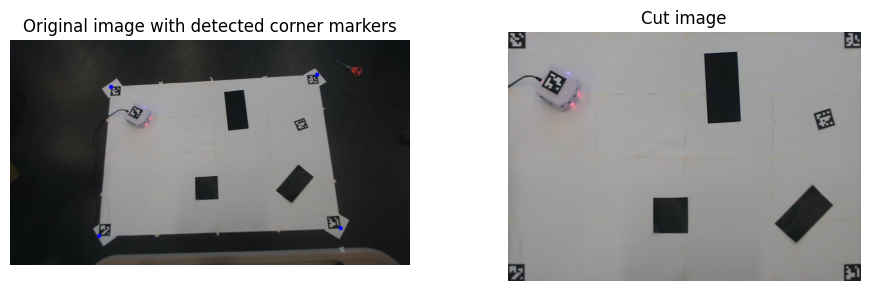

In [14]:
# Detect the corners markers
markers = Marker()
detected_markers = markers.detect(cam,n_iterations=1)
frame_with_markers = frame.copy()
# Display the coordinates of the markers on the image
for k in detected_markers.keys():
    if k in IDS_CORNER_MARKERS:
        marker = detected_markers[k]
        # Draw the origin of the marker with a different color
        cv2.circle(frame_with_markers,tuple(np.array(marker["points"][0]).astype(int)),10,(0,0,255),-1)

# Use the markers found to compute a transformation matrix such the corner markers are in the vertices of a square
_,frame_cut = cam.get_frame()
frame_cut = cv2.cvtColor(frame_cut, cv2.COLOR_BGR2RGB)

# Display frame with markers next to frame_cut
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_with_markers)
ax[0].set_position([0.05,0.05,0.4,0.9])
ax[0].set_title("Original image with detected corner markers")
ax[1].imshow(frame_cut)
ax[1].set_title("Cut image")
# Remove the axis
for a in ax:
    a.axis("off")
plt.show()

#### 3.1.3 Obstacles detection and enlargement

To detect the obstacles we have done the following:
- <b>Thresholding</b>: after converting the image obtained from the camera in a greyscale image we have converted it in a binary image by using the OpenCV function `threshold`. The threshold value has been chosen by trial and error. <br> Below we have plotted (from left to right) the original image, the greyscale image and the binary image.
<br><br><img src="./_report_data/img/vision_original.png" width="32%"><img src="./_report_data/img/vision_grey.png" width="32%"><img src="./_report_data/img/vision_thresholding.png" width="32%"> <br><br>
- <b>Contours detection and area computation </b>: we have used the OpenCV function `findContours` to find the contours of all the objects in the binary image. After that we have computed the area of each object and we have sorted them in ascending order. To avoid considering the ArUco markers as obstacles (since they are black too) or any noise we consider only the first `number_of_obstacles` contours. <br> Due to this method we have the limitation that the obstacles must be the biggest objects in the image (and this limits the possible size of the ArUco markers, as discussed in the previous section). <br><br>
<img src="./_report_data/img/vision_obstacles.png" width="40%">
- <b>Obstacles smoothing and vertices detection</b>: the contour obtained with the previous steps are not always precise, might have ondulated borders or other non accuracies that depends on the light conditions. To solve these problems we firstly compute the convex hull of each polygon (to have only straight segments) and then we apply the OpenCV function `approxPolyDP` to find convex hulls in order to reduce the number of vertices. After this step we obtain a list of polygons that represent the obstacles with a number of points equal to the number of vertices of the polygon. The main limitation of this method is that we must have a convex polygon as obstacle and that with some specific object shapes we have more vertices than number of points (mainly with figures with a high number of vertices) <br><br>
- <b>Obstacles enlarging</b>: Finally we enlarge the obstacles to take into account the size of the robot. The enlarging value has been chosen by trial and error.

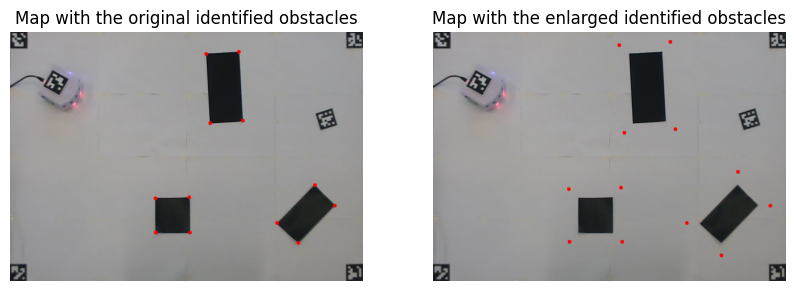

In [15]:
# Create a map
m = Map(cam,number_of_obstacles=3,robot_size=25)
# Find the obstacles
m.findObstacles()
# Create a map with the obstacles vertices
map_with_obstacles = frame_cut.copy()
# Draw the original obstacles on the map_with_obstacles
for obstacle in m.obstacles_original:
    for p in obstacle:
        pinv = p.copy()
        # Invert the y coordinate
        pinv = tuple(np.array([pinv[0], pinv[1]]).astype(int))
        cv2.circle(map_with_obstacles,pinv,5,(255,0,0),-1)
# Create a map with the enlarged obstacles
map_with_enlarged_obstacles = frame_cut.copy()
# Draw the enlarged obstacles on the map_with_enlarged_obstacles
for obstacle in m.obstacles:
    for p in obstacle:
        pinv = p.copy()
        # Invert the y coordinate
        pinv = tuple(np.array([pinv[0],h_px-pinv[1]]).astype(int))
        cv2.circle(map_with_enlarged_obstacles,pinv,5,(255,0,0),-1)
# Display the maps
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(map_with_obstacles)
ax[0].set_title("Map with the original identified obstacles")
ax[1].imshow(map_with_enlarged_obstacles)
ax[1].set_title("Map with the enlarged identified obstacles")
# Remove the axis
for a in ax:
    a.axis("off")
plt.show()


#### 3.1.4 Final goal and initial position detection

The initial and final goal are defined, as for the vertices of the area of the map, by ArUco markers.

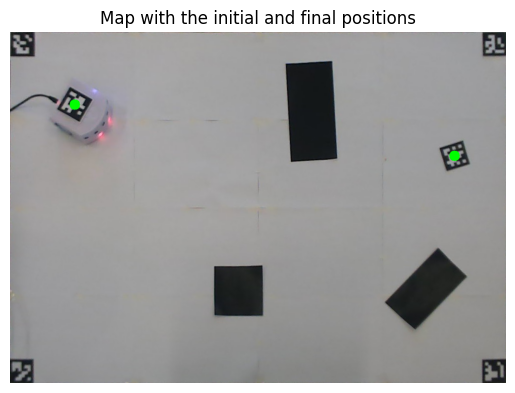

In [16]:
# Find initial and final positions
initial, _, final = m.getInitialFinalData()

# Display the initial and final positions
map_with_initial_final = frame_cut.copy()
# Draw the initial and final positions on the map_with_initial_final
for p in [initial,final]:
    pinv = p.copy()
    # Invert the y coordinate
    pinv[1] = frame_cut.shape[0]-pinv[1]
    pinv = tuple(np.array(pinv).astype(int))
    cv2.circle(map_with_initial_final,pinv,10,(0,255,0),-1)
# Display the map
plt.imshow(map_with_initial_final)
plt.title("Map with the initial and final positions")
plt.axis("off")
plt.show()

#### 3.1.5 Map creation

Finally all the elements are put together to create the map.

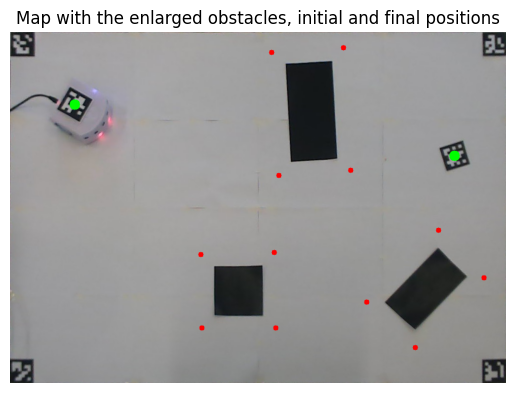

In [17]:
# Insert enlarged obstacles, initial and final positions in the map
fullMap = frame_cut.copy()

# Draw the enlarged obstacles on the fullMap
for obstacle in m.obstacles:
    for p in obstacle:
        # Invert the y coordinate
        p_inv = p.copy()
        p_inv = tuple(np.array(p_inv).astype(int))
        cv2.circle(fullMap,(p_inv[0],h_px - p_inv[1]),5,(255,0,0),-1)

# Draw the initial and final positions on the fullMap
for p in [initial,final]:
    # Invert the y coordinate
    p_inv = p.copy()
    p_inv[1] = frame_cut.shape[0]-p[1]
    p_inv = tuple(np.array(p_inv).astype(int))
    cv2.circle(fullMap,p_inv,10,(0,255,0),-1)

# Display the map
plt.imshow(fullMap)
plt.axis("off")
plt.title("Map with the enlarged obstacles, initial and final positions")
plt.show()

### 3.2 Real time detection of position and orientation

The real position and orientation are estimated from the ArUco marker which is put on top of the robot. The position is computed as the center of the marker and the orientation is computed as the angle between the horizontal axis and the line that connects the first (origin in the photo below) and the second point (point with label 2 in the marker below) of the marker.
<!-- Add an image -->
<center><img src="./_report_data/img/thymio.jpg" width="25%"></center>



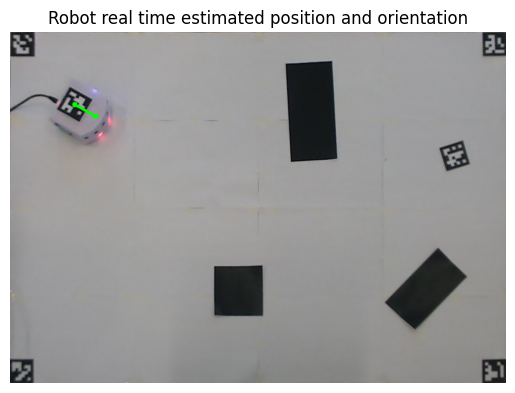

In [18]:
# Draw the position and the orientation
orientationPositionMap = frame_cut.copy()

# Obtain the position and the orientation
p,_,theta = m.cameraRobotSensing()

# Draw the robot position
p_inv = p.copy()
p_inv[1] = frame_cut.shape[0]-p[1]
p_inv = tuple(np.array(p_inv).astype(int))
cv2.circle(orientationPositionMap,p_inv,5,(0,255,0),-1)

# Draw the robot orientation
p2 = (p_inv[0]+50*np.cos(theta),p_inv[1]-50*np.sin(theta))
p2 = tuple(np.array(p2).astype(int))
cv2.arrowedLine(orientationPositionMap,p_inv,p2,(0,255,0),3)

# Display the map
plt.imshow(orientationPositionMap)
plt.title("Robot real time estimated position and orientation")
plt.axis("off")
plt.show()

### 3.3 Limitations and Downsides

## 4. Global Navigation
The goal of the global navigation part is to first, from the information of the vision part, create an environment capable of identifying all the possible paths, and then to find the optimal path from a start to a goal point. Finally, a global controller is designed, which updates the wheels velocity in order to make the robot follow the optimal path. 
The global controller is switched on when no obstacles are detected, otherwise a local version of the controller (explained further), updates the velocities. The scheme below illustrates the design of the main controller.

<br>
<center><img src="./_report_data/img/controllers_scheme.png" width = 60% height = 60%></center>

All the code is implemented in the `main.py` function of the `global_navigation` folder.

### 4.1 Initializing the 'Global' class


In [ ]:
glob = Global(m.obstacles)

### 4.2 Creation of the visibility graph

The visibility graph approach is used to identify the possible path. Since the environment is made of sparse polygon shaped obstacles, this method is chosen for simplicity, and completeness.


To build such a graph, the Shapely library is used to facilitate the creation of geometrical objects such as points, lines, and polygons. 

The use of the Shapely library is not only very convenient but also allows the obstacles to take any arbitrary polygon form, with as many edges as needed, and can also be concave or convex.

First, lines are created between all points. Then polygons are created from the obstacles points. Finally, lines which cross these polygons or that are inside them, are deleted.


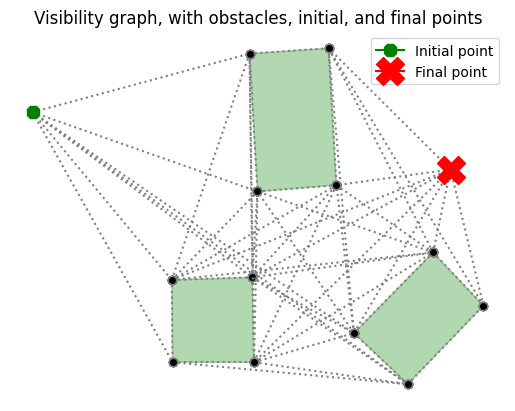

In [20]:
# Create visibility graph,and plot it
glob.plot_visibility(initial, final)

### 4.3 Building the weight matrix

Once the visibility graph is created, a weight matrix is designed in order to store the cost to go from a point to another. The length of each visible line is chosen to be the cost. 
This weight matrix is built iteratively over all lines. The library Shapely is again used, in order to compute the length of each line. 

### 4.4 Dijkstra algorithm 

To compute the optimal path, the Dijkstra algorithm is best suited. Since the environment is simple, there is not much gain by using a heuristic, so between A* and Dijkstra, we have chosen the second one. The path found is optimal.

The 'dijkstra' library implements the algorithm. It takes as input a graph made of edges which corresponds to the weight matrix just built. It outputs the shortest path from the initial node to every other node in the graph, along with the corresponding distances. The optimal path to the wanted final goal is then stored in the 'optimal_path' array.


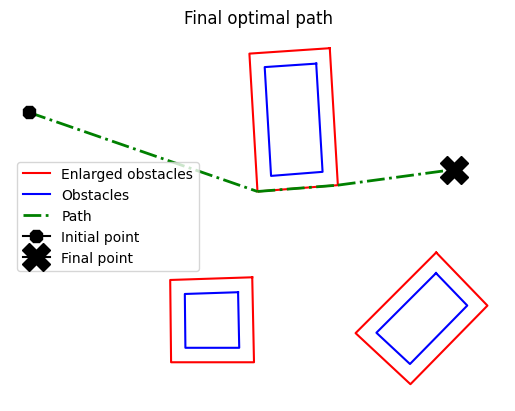

In [21]:
# Finding optimal path
glob.find_optimal_path(initial, final)

# Plotting optimal path
m.plot(initial, final, path= glob.optimal_path)

### 4.5 Global controller 

* The global controller is switched-on when no local obstacles are sensed. At each time iteration, it updates the current goal point by checking if the distance between the estimated position and current goal is small enough. Then it sets the wheel's velocity in two ways. 

    1) When the difference between the trajectory direction and the estimated direction is under a certain threshold, this difference in angle is scaled, and added/removed to the wheels nominative velocity.
    This command constantly updates wheels velocity so the path is smoothly followed.

    2) When the difference in angle is too large -in the case of change of intermediate goal point- the velocities take the value of +/- the scaled angle difference. This command allows the robot to efficiently change direction when needed. However, when the difference in angle is superior than a certain threshold, a fixed maximum rotational speed is assigned to the wheels velocities. This was done to smoothen the changes in direction for the Kalman filter, so they are not too abrupt, otherwise the stability is threatened during camera hiding.

* The given motor command is controlled against the current motor speed. If the difference is considered too big, both commands are scaled down. This was done because we found that spikes in wheel commands gave the Kalman filter an unpredictable behavior when the camera was off. The speed is therefore smoothened out.


* For the following local navigation part, another function is created: when a local obstacle is placed too close to an intermediate goal point, the local controller needs to switch to the next goal point, otherwise the robot gets stuck. This is done by calling the function `glob.local_goal_point_update`, which updates the goal point if the distance between the robot and the goal point is too small.

* **Limitations:** This approach is very sensitive to the choice of tuning parameters, which are all the angle and distance thresholds but also the coefficients scaling the velocity updates.


**Demo:** The video below shows the behavior of the robot when the global controller is actuated:

<br>
<center><img src="./_report_data/report_gifs/global_navigation.gif" width = 50% height = 50%></center>

### 4.6 Kidnapping

The kidnapping mode is detected when the difference between estimated position (from the Kalman filter) and the measured position (from the camera) is superior than a threshold. This threshold has been found experimentally.

When this happens the motors speed are set to zero.
Then, the optimal path is computed all over again, the current goal point is reset, and the global controller is re-activated with these new inputs.

**Demo:** The video below shows the behavior of the robot when the kidnapping mode is activated:

<br>
<center><img src="./_report_data/report_gifs/kidnapping.gif" width = 50% height = 50%></center>


## 5. Local Navigation
### 5.1 Local Obstacle Detection

The `local_obstacle` method takes the list `prox_horizontal` as an argument, which represents all proximity sensors readings in the horizontal direction. It determines whether there is a local obstacle based on these readings and updates the `active_avoidance` flag accordingly. The `last_obstacle_time` is a timestamp indicating the last time the robot stopped seeing a local obstacle. It is used to determine how long the robot has been in the active avoidance state without detecting an obstacle.

One really needs to distinguish the difference between *detection* and *avoidance* states :
- *detection* means the robot sees an obstacle in front of him ;
- *avoidance* means we are avoiding the previously detected obstacle (we're in the *local controller*). We stay in this state even a few seconds after seeing the obstacle for the last time.

Fine-tuning the `LOCAL_AVOIDANCE_DELAY` parameter involved experimenting with multiple values to observe their impact on the robot's behavior. The critical consideration was to ensure the robot had sufficient time for avoidance maneuvers without unnecessarily prolonging the avoidance state. The iterative testing aimed to find a balance that optimally addressed obstacles while maintaining efficient navigation. The chosen value contributes to the overall success of the obstacle avoidance strategy, allowing the robot to make informed path adjustments without unnecessary delays or abrupt maneuvers. A similar iterative approach was used to set the `DIST_THRESH_LOCAL` value.

The following flowchart shows how the detection part is structured. The output is used to know if we shall call the local controller or not.

<center><img src="./_report_data/img/local_scheme.png" width="70%"></center>

### 5.2 Local Motion Controller

The `local_controller` method is responsible for determining the robot's motion commands based on proximity sensor readings and the desired orientation. It calculates the left and right wheel speeds to achieve the desired orientation and adjusts them based on the detected obstacles.

The way of computing the proximity sensors values and using them to change the speed of the robot was taken from the *Session 4 of the Basics Mobile Robotics course*.

**Demo:** The video below shows the behavior of the robot when a local obstacle is placed on the path:
<br>
<center><img src="./_report_data/report_gifs/local_navigation.gif" width = 50% height = 50%></center>

### 5.3 Limitations and Downsides

While the provided code efficiently addresses local obstacle avoidance and motion control, it comes with certain limitations that may impact its performance in more complex scenarios.

#### 3.3.1 Neglecting Global Obstacles
The code currently does not incorporate information about global obstacles in the local controller. Given the small size of the map, this omission can lead to collisions with global obstacles. The abrupt changes in path induced by local obstacle avoidance may not align with the presence and positions of larger, more distant obstacles. This oversight becomes critical in confined spaces, where a local avoidance maneuver might inadvertently result in collisions with global obstacles due to the limited scope of the environment.

Note: In our specific case, where the setup is small, it is essential to strategically place local obstacles to minimize the likelihood of encountering scenarios where global obstacles become a significant concern during local avoidance.

#### 3.3.2 Lack of Global Obstacle Position Consideration
The code does not account for the position of close global obstacles when deciding on the side to turn for avoiding local obstacles. In situations where a local obstacle is present, and there is a nearby global obstacle (very likely considering 3.3.1), the robot may not make an informed decision about the safest direction to turn. Considering the proximity and position of global obstacles could enhance the robot's ability to navigate dynamically changing environments and avoid collisions effectively.

#### 5.3.3 Static Avoidance in Zero Velocity Condition
The code introduces a static avoidance mechanism by setting speed values to -2 when both `spLeft` and `spRight` are zero. While this prevents the robot from being completely static, it may not be the most optimal solution for all situations. A more nuanced approach, considering the robot's current state and environment, could improve overall motion control.

## 6. Filtering

### 6.1 Model of the Kalman Filter
#### Estimation
The filtering of the values is done thanks to a Kalman Filter. We estimate 5 states using the Kalman Filter :
$$\begin{bmatrix} x \\ y \\ \theta \\ v_l \\ v_r \end{bmatrix}$$
with x and y being the coordinates of the Thymio, $\theta$ the orientation, and $v_l$ and $v_r$ the speeds of the left and right wheels respectively. 

The robot's behavior can therefore be modeled as the following:

$$ x^{t+1}  = A \cdot x^t + B \cdot u^t $$

With A being the state transition matrix:
$$ A = \begin{bmatrix}  1 & 0 & 0 & 0.5*dt*w_{conv}*cos(\theta) & 0.5*dt*w_{conv}*cos(\theta) \\ 0 & 1 & 0 & 0.5*dt*w_c*sin(\theta) & 0.5*dt*w_c*sin(\theta) \\ 0 & 0 & 1 & -dt*\frac{w_{conv}}{w_{base}} & dt*\frac{w_{conv}}{w_{base}} \\ 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 1  \end{bmatrix}$$

In here $dt$ is the time differential between the samples, $w_{conv}$ is the conversion factor to get from the wheel speeds to cm/s as measured in exercise 8, and $w_{base}$ is the wheel base of the Thymio, necessary to find the turning angle.

B is Control Input matrix, to convert the inputs of the system into state changes.

Here B is : 
$$ B = \begin{bmatrix} 0.5*dt*cos(\theta)*w_{conv} & 0.5*dt*cos(\theta)*w_{conv} \\ 0.5*dt*sin(\theta)*w_{conv} & 0.5*dt*sin(\theta)*w_{conv} \\-dt*\frac{w_{conv}}{w_{base}}  & dt*\frac{w_{conv}}{w_{base}} \\ 1 & 0 \\ 0 & 1 \end{bmatrix}$$

#### Noise

Noise also has to be considered when designing a Kalman Filter. The two matrices that give us the system's noise are the R and Q matrices, respectively the measurement noise and process noise. These matrices have to be tuned to best fit the behavior of the robot. Here after some tuning we end with the following matrices:

$$ R = \begin{bmatrix} \sigma_{gps-x}^2 & 0 & 0 & 0 & 0 \\ 0 &sigma_{gps-y}^2 & 0 & 0 & 0 \\ 0 & 0 & \sigma_{gps-\theta}^2 & 0 & 0 \\ 0 & 0 & 0 & \sigma_{vx}^2 & 0 \\ 0 & 0 & 0 & 0 & \sigma_{vy}^2 \end{bmatrix} $$

with the $\sigma$ being the covariance estimated in the calibration experiments. After tuning these parameters we end up with the following values:
- $\sigma_{gps-x} = \sigma_{gps-y} = 0.1 $
- $\sigma_{theta} = 0.9$
- $\sigma_{vx} = \sigma_{vy} = 0.5$

If the camera is detected as being obstructed we put the values of $\sigma_{gps-x}$, $\sigma_{gps-y}$, $\sigma_{gps-\theta}$ to 10000000, an arbitrarily large number to make sure that its covariance is not updated. We keep the measures of the wheel speeds as they are still important when the camera is unused (`camera_state == 'off'`).

$$ Q = \begin{bmatrix} 0.0442 & 0 & 0 & 0 & 0 \\ 0 & 0.0442 & 0 & 0 & 0 \\ 0 & 0 & 0.0442 & 0 & 0 \\ 0 & 0 & 0 & 0.0442 & 0 \\ 0 & 0 & 0 & 0 & 0.0442 \end{bmatrix} $$


#### Overall Kalman Process:

- State estimation: 
$$ X^{t+1}_{est} = A \cdot X^t + B \cdot U $$

- Calculation of the Prediction Covariance
$$P = A \cdot P \cdot A^T + Q$$

- Update of the Kalman Gain :
    - S is and intermediary matrix to help determine K
    - K is the Kalman Gain of the System
$$S = H \cdot P \cdot H^T + R$$

$$K = P \cdot H^T \cdot S^{-1}$$

- We compare and adjust the value of the estimation with the measured value based on the size of the Kalman Gain:
$$ X^{t+1} = X^{t+1}_{est} + K \cdot(Z - X^{t+1}_{est})$$

- We update the value of the covariance of the system:

$$ P = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 1 \\ \end{bmatrix} - K \cdot H \cdot P $$

With $Z$ being the measurements of the system, so the coordinate and orientation taken from the GPS and the left and right wheels speeds:
$$ Z = \begin{bmatrix} gps_x \\ gps_y \\ gps_\theta \\ v_{wl} \\ v_{wr} \end{bmatrix} $$


#### Observations on the Kalman Filter:
When we first implemented the Kalman we found a few issues and had to tinker with its parameters to make it work with the rest of the code:
- One of the first issues that popped up was that it was heavily sensible to sharp changes in the speed of the wheels. This was resolved by implementing a rate control, where the wheel accelerations are capped, making very sharp accelerations impossible.

- Another issue is that the wheel sensors are very noisy and since the angle is based on the difference between both sensors, it sometimes jumped around when the camera was off. This was resolved by implementing a buffer, where we take the average of the last 5 estimates to determine the current angle, but just when the camera is off. This is why the camera is weighed much more than the wheel speeds.




## 7. Demo

In [1]:
from demo import *
await demo("kalman")

## 8. Conclusions

